# Custom Signal Injection
This tutorial shows how to add custom signal sources to synthetic voltage data.

If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. Once you have CuPy installed, to enable GPU acceleration you must set `SETIGEN_ENABLE_GPU` to '1' in the shell or in Python via `os.environ`. It can also be useful to set `CUDA_VISIBLE_DEVICES` to specify which GPUs to use.

In [1]:
# !pip install cupy-cuda110

In [2]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import setigen as stg

In [4]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

We can create the backend elements up front, before the `Antenna` and signals.

In [5]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

## Adding a custom signal
Likewise, we can create the backend object before actually adding signals and noise to the `Antenna`, since data is only calculated when we call the `record` method. This way, we can actually use parameters specific to the background / recording in order to figure out how to construct the signal in the first place.

In [6]:
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=1)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

We first add some Gaussian noise:

In [7]:
antenna.x.add_noise(0, 1)

### Custom signals

Similarly, instead of the using `add_signal` method, we can add signal "sources", functions that accept `ts` as input and add the appropriate real voltages to the antenna data streams. Here's an example, utilizing the `scipy.signal` library. Alternatively, if you have `cusignal` installed, the injection will also be GPU accelerated.

Note that if you have CuPy installed, arrays will specifically be CuPy arrays, and won't work automatically with NumPy methods. This is mainly important if one is writing custom signal source functions, but keep in mind that CuPy is essentially a stand-in for NumPy, as is `cusignal` for `scipy.signal`. Of course, you can also easily manually convert between CuPy and NumPy via `cupy.asnumpy` and `cupy.asarray`.

Generating a quadratic signal, scaled to amplitude 0.004:

In [8]:
try:
    from cupyx.scipy.signal import chirp
    print("Using cupy's chirp")
except ImportError:
    try:
        from cusignal import chirp
        print("Using cusignal's chirp")
    except ImportError:
        from scipy.signal import chirp
        print("Using scipy's chirp")

def my_signal(ts):
    return 0.004 * chirp(t=ts,
                         f0=6002.2e6,
                         t1=rvb.time_per_block,
                         f1=6002.3e6,
                         method='quadratic')

antenna.x.add_signal(my_signal)

Using cusignal's chirp


Note that we can use properties specific to the backend, like `RawVoltageBackend.time_per_block`, which computes the amount of time represented in one block of raw data, for convenience in sculpting the input signal.

## Recording synthetic data
Now that we have all the pieces of the backend created, we can now create GUPPI RAW files using `RawVoltageBackend.record()`. There are two modes to record, `num_blocks` and `obs_length`. The former allows you to specify how many data blocks to record, as defined by the RAW format, and the latter computes the number of required blocks from the desired observation length (in seconds). The `header_dict` parameter allows for overwriting existing header values / adding additional keywords. For example, TurboSETI requires the `TELESCOP` parameter to be set to "GBT" to run on certain types of RAW files, so you can overwrite this parameter using `header_dict`.

`raw_file_stem` is the path + prefix for your saved GUPPI RAW file.

In [9]:
rvb.record(output_file_stem='example_custom_signal',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

Blocks: 100%|██████████| 1/1 [02:06<00:00, 126.20s/it]


## Taking a look
If `rawspec` is installed, you can unpack the data as such:

In [10]:
!rawspec -f 1024 -t 16 -d . example_custom_signal

working stem: example_custom_signal
opening file: example_custom_signal.0000.raw
opening file: example_custom_signal.0001.raw [No such file or directory]
output product 0: 64 spectra


Using `blimpy` to open the resulting filterbank file and plotting the data:

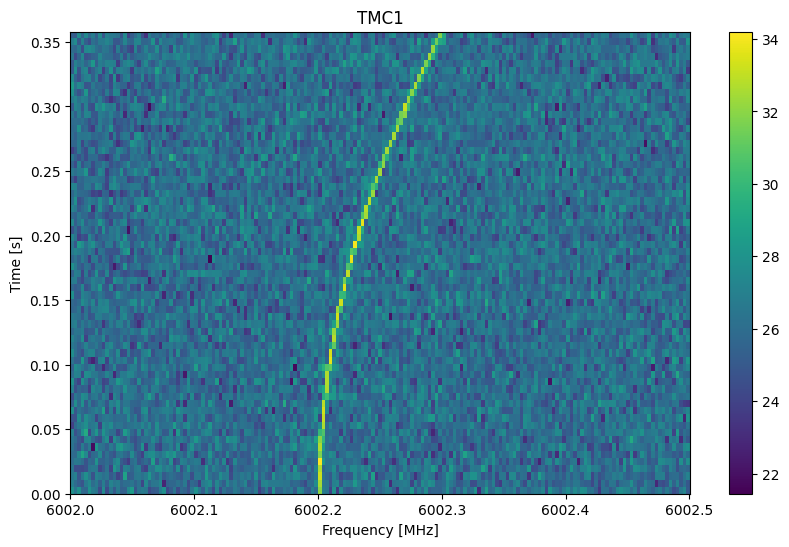

In [11]:
wf = bl.Waterfall('example_custom_signal.rawspec.0000.fil',
                  f_start=6002.0,
                  f_stop=6002.5)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

Integrating over time:

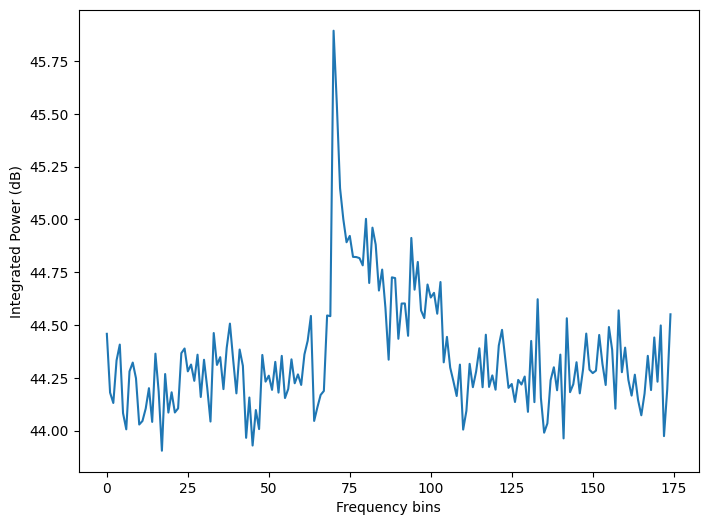

In [12]:
def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

x = db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()